## Imports😀

In [145]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import csv

## Exploring the Markup🧐

main_url = "https://en.wikipedia.org/wiki/"
movie_name = "The_Shawshank_Redemption"
r = requests.get(main_url + movie_name)
soup = BeautifulSoup(r.content,"html.parser")
contents = soup.prettify()
print(contents)

In [6]:
table_body = soup.select_one("table.infobox.vevent")
table_body

<table class="infobox vevent" style="width:22em;font-size:90%;"><tbody><tr><th class="summary" colspan="2" style="text-align:center;font-size:125%;font-weight:bold;font-size:110%;font-style:italic;">The Shawshank Redemption</th></tr><tr><td colspan="2" style="text-align:center"><a class="image" href="/wiki/File:ShawshankRedemptionMoviePoster.jpg" title='A man stands with his back to the viewer and his arms outstretched, looking up to the sky in the rain. A tagline reads "Fear can hold you prisoner. Hope can set you free."'><img alt='A man stands with his back to the viewer and his arms outstretched, looking up to the sky in the rain. A tagline reads "Fear can hold you prisoner. Hope can set you free."' class="thumbborder" data-file-height="327" data-file-width="220" decoding="async" height="327" src="//upload.wikimedia.org/wikipedia/en/8/81/ShawshankRedemptionMoviePoster.jpg" width="220"/></a><div style="font-size:95%;padding:0.35em 0.35em 0.25em;line-height:1.25em;">Theatrical release

## Writing the Code for Scraping Info Box on Wiki

In [227]:
"""
This function helps us clean our string a little
wikipedia uses sub text square brackets as hyper links
as they have no value in the dataset we remove them with this function
"""
def remove_brackets(data_value):
    while "[" in data_value and "]" in data_value: 
        start = list(data_value).index("[")
        end = list(data_value).index("]")
        old = data_value
        data_value = ""
        for i, chr in enumerate(list(old)):
            if start <= i <= end:
                continue
            data_value += chr
        
    return str(data_value).strip()
        
"""
in the pandas dataframe each array object is stored as 
a string instance therefore we need a method to dump them
back into an array to access each index of them
"""
def dumpArray(text):
    if text[0] != "[" or text[-1] != "]":
        return text
    array = text[1:-1].split(",")
    new = []
    for elem in array:
        new.append(elem.strip()[1:-1])
    return np.array(new)

"""
for this function we pass in a "td" html element
it returns us a list if there is at least one "li" element in the data
this list contains each "li" element otherwise it returns single value
"""
def get_contents(row_data):
    try:
        if row_data.find("li"):
            return [item.get_text(" ",strip=True).replace("\xa0"," ") for item in row_data.find_all("li")]
    except: 
        return -1
    return row_data.get_text(" ",strip=True).replace("\xa0"," ")
    
"""
this function loops over each table data in the movie info box table
you can pass in an json object optionally if you already have some data
related to the movie else it will be interpreted as an empty dictionary
this function is the main function used in the create_dataset function
"""
def get_data(movie="",movie_url="",json={}):
    main_url = "https://en.wikipedia.org/wiki/"
    movie_name = movie.replace(" ", "_")
    if movie_url:
        main_url = "https://en.wikipedia.org/"
        r = requests.get(movie_url)
    else: 
        r = requests.get(main_url + movie_name)
    if r.status_code == 404: 
        print("status code 404")
        return json
    soup = BeautifulSoup(r.content,"html.parser")
    table_body = soup.select_one("table.infobox.vevent")
    if not table_body:
        print("table body not found")
        return json
    for idx, row in enumerate(table_body.find_all("tr")):
        if not idx: 
            json["title"] = row.get_text(strip=True)
        elif idx == 1: 
            continue
        else: 
            try:
                data_key = row.find("th").get_text(" ",strip=True)
            except ex as e:
                print(f"{e} on {idx}")                
                return json
            data_value = get_contents(row.find("td"))
            data_key = data_key.capitalize()
            if data_value == -1: 
                print("couldn't get contents on", str(idx))
                return json
            data_value = remove_brackets(data_value)
            json[data_key] = data_value
    return json

"""
as an argument we pass in a movies iterable object
the function will loop over each movie in the movies iterable
and create a dataset by scraping related info for each movie
the function will return a pandas dataframe
"""
def create_dataset(movies):
    for idx,movie in enumerate(movies): 
        data = get_data(movie)
        if idx == 0:
            df = pd.DataFrame(data,index=[0])
        if idx % 10 == 0:
            print(f"Currently on {idx}")
        else:
            try:
                df = df.append(data,ignore_index=True)
            except:
                print(str(idx) + " " + movie.upper() + " can't be found")
                
    return df

## Highest Grossing Movies 💸

In [88]:
base_url = "https://en.wikipedia.org"
url = "https://en.wikipedia.org/wiki/List_of_highest-grossing_films"
r = requests.get(url)
soup = BeautifulSoup(r.content,"html.parser")
contents = soup.prettify()
print(contents)

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of highest-grossing films - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"YEEDSEPBrqzcPcr2Gu6ligAAAEY","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_highest-grossing_films","wgTitle":"List of highest-grossing films","wgCurRevisionId":1009841614,"wgRevisionId":1009841614,"wgArticleId":59892,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["CS1 uses Russian-language script (ru)","CS1 Russian-language sources (ru)","CS1 errors: missing periodical","

In [89]:
table_body = soup.select_one("table.wikitable.sortable tbody")
table_body

<tbody><tr>
<th scope="col">Rank
</th>
<th scope="col">Peak
</th>
<th scope="col">Title
</th>
<th scope="col">Worldwide gross
</th>
<th scope="col">Year
</th>
<th class="unsortable" scope="col">Reference(s)
</th></tr>
<tr>
<td>1
</td>
<td>1
</td>
<th scope="row"><i><a href="/wiki/Avengers:_Endgame" title="Avengers: Endgame">Avengers: Endgame</a></i>
</th>
<td align="right">$2,797,800,564
</td>
<td data-sort-value="2019-04" style="text-align:center;">2019
</td>
<td style="text-align:center;"><sup class="reference" id="cite_ref-endgame_14-0"><a href="#cite_note-endgame-14">[# 1]</a></sup><sup class="reference" id="cite_ref-endgame_peak_15-0"><a href="#cite_note-endgame_peak-15">[# 2]</a></sup>
</td></tr>
<tr>
<td>2
</td>
<td>1
</td>
<th scope="row"><i><a href="/wiki/Avatar_(2009_film)" title="Avatar (2009 film)">Avatar</a></i>
</th>
<td align="right">$2,790,439,000
</td>
<td style="text-align:center;">2009
</td>
<td style="text-align:center;"><sup class="reference" id="cite_ref-avatar_16

In [101]:
def create_dataset2():
    json_data = []
    # first row is a header row
    for idx, row in enumerate(table_body.select("tr")[1:]):
        data = {}
        row_data = row.select("td")
        data["rank"] = int(row_data[0].get_text(strip=True))
        data["link"] = base_url + row.select_one("i a")["href"]
        data["year"] = int(row_data[3].get_text(strip=True)) 
        
        try:
            data = get_data(movie_url=data["link"],json=data)
        except Exception as e:
            print(f"{e} on {idx}")
        
        try: 
            gross = int(row_data[2].get_text(strip=True)[1:].replace(",","_"))
            data["gross"] = gross
        except Exception as e: 
            print(f"{e} on {idx}")
        else:
            if idx == 0:
                df = pd.DataFrame(data,index=[0])
            else:
                df = df.append(data,ignore_index=True)
        
        if idx % 10 == 0:
            print("Currently on:",idx,data["link"])
        
    return df

In [ ]:
df = create_dataset2()

Currently on: 0 https://en.wikipedia.org/wiki/Avengers:_Endgame


In [114]:
df.dropna(axis=1,how="any",inplace=True)

In [116]:
df.columns.values

array(['rank', 'link', 'year', 'title', 'Directed by', 'Produced by',
       'Starring', 'Music by', 'Edited by', 'Distributed by',
       'Release date', 'Running time', 'Language', 'Budget', 'Box office',
       'gross'], dtype=object)

In [119]:
df.columns = map(lambda x: x.capitalize(),df.columns)

## Save Data

In [212]:
df.to_csv("../data/highest_gross.csv",index=False)

## Load Data

In [213]:
df = pd.read_csv("../data/highest_gross.csv")

## Clean Data

In [128]:
df.head()

,Rank,Link,Year,Title,Directed by,Produced by,Starring,Music by,Edited by,Distributed by,Release date,Running time,Language,Budget,Box office,Gross
0,1,https://en.wikipedia.org/wiki/Avengers:_Endgame,2019,Avengers: Endgame,"['Anthony Russo', 'Joe Russo']",Kevin Feige,"['Robert Downey Jr.', 'Chris Evans', 'Mark Ruf...",Alan Silvestri,"['Jeffrey Ford', 'Matthew Schmidt']",Walt Disney Studios Motion Pictures,"['April 22, 2019 ( 2019-04-22 ) ( Los Angeles ...",181 minutes,English,$356 million,$2.798 billion,2797800564
1,2,https://en.wikipedia.org/wiki/Avatar_(2009_film),2009,Avatar,James Cameron,"['James Cameron', 'Jon Landau']","['Sam Worthington', 'Zoe Saldana', 'Stephen La...",James Horner,"['Stephen Rivkin', 'John Refoua', 'James Camer...",20th Century Fox,"['December 10, 2009 ( 2009-12-10 ) (London)', ...",162 minutes,English,$237 million $9 million+ (re-release),$2.79 billion,2790439000
2,3,https://en.wikipedia.org/wiki/Titanic_(1997_film),1997,Titanic,James Cameron,"['James Cameron', 'Jon Landau']","['Leonardo DiCaprio', 'Kate Winslet', 'Billy Z...",James Horner,"['Conrad Buff', 'James Cameron', 'Richard A. H...","['Paramount Pictures (North America)', '20th C...","['November 1, 1997 ( 1997-11-01 ) ( Tokyo )', ...",195 minutes,English,$200 million,$2.195 billion,2194439542
3,4,https://en.wikipedia.org/wiki/Star_Wars:_The_F...,2015,Star Wars: The Force Awakens,J. J. Abrams,"['Kathleen Kennedy', 'J. J. Abrams', 'Bryan Bu...","['Harrison Ford', 'Mark Hamill', 'Carrie Fishe...",John Williams,"['Mary Jo Markey', 'Maryann Brandon']",Walt Disney Studios Motion Pictures,"['December 14, 2015 ( 2015-12-14 ) (Los Angele...",135 minutes,English,['$306 million [2] [3]'],$2.068 billion,2068223624
4,5,https://en.wikipedia.org/wiki/Avengers:_Infini...,2018,Avengers: Infinity War,"['Anthony Russo', 'Joe Russo']",Kevin Feige,"['Robert Downey Jr.', 'Chris Hemsworth', 'Mark...",Alan Silvestri,"['Jeffrey Ford', 'Matthew Schmidt']",Walt Disney Studios Motion Pictures,"['April 23, 2018 ( 2018-04-23 ) ( Dolby Theatr...",149 minutes,English,$325–400 million,$2.048 billion,2048359754


In [132]:
# check if there are null values
print(df.shape)
df.isnull().sum()

(48, 16)


Rank              0
Link              0
Year              0
Title             0
Directed by       0
Produced by       0
Starring          0
Music by          0
Edited by         0
Distributed by    0
Release date      0
Running time      0
Language          0
Budget            0
Box office        0
Gross             0
dtype: int64

In [142]:
df.index

RangeIndex(start=0, stop=48, step=1)

In [152]:
def histogram_intersection(a,b):
    v = np.minimum(a,b).sum().round(decimals=1)
    return v
df.corr(method="pearson")

,Rank,Year,Gross
Rank,1.000000,-0.337085,-0.787876
Year,-0.337085,1.000000,0.096371
Gross,-0.787876,0.096371,1.000000


In [167]:
df["Running time"]

0                  181 minutes
1                  162 minutes
2                  195 minutes
3                  135 minutes
4                  149 minutes
5                  124 minutes
6                  118 minutes
7                  143 minutes
8                  137 minutes
9                  103 minutes
10                 141 minutes
11                 134 minutes
12                 130 minutes
13                 152 minutes
14                 128 minutes
15                 129 minutes
16                 118 minutes
17                 131 minutes
18                  91 minutes
19                 147 minutes
20                 143 minutes
21                 201 minutes
22                 129 minutes
23                 124 minutes
24                 154 minutes
25                 143 minutes
26                 165 minutes
27                 165 minutes
28                 122 minutes
29                 142 minutes
30                 100 minutes
31                 103 minutes
32      

In [173]:
def convert_run_time(run_time):
    new = ""
    run_time = run_time.strip()
    for char in run_time:
        if char.isdecimal():
            new += char
        else:
            return int(new)

In [203]:
# convert each run time string into integers
df["Running time"] = df["Running time"].map(convert_run_time)

In [189]:
# take a look at the correlation between the numeric values
df.corr()

,Rank,Year,Gross,Running Time
Rank,1.000000,-0.337085,-0.787876,-0.300031
Year,-0.337085,1.000000,0.096371,-0.224268
Gross,-0.787876,0.096371,1.000000,0.388657
Running Time,-0.300031,-0.224268,0.388657,1.000000


In [214]:
# renaming the column accordingly to the int values
df.rename(columns={"Running time":"Running Time(int)"},inplace=True)

In [217]:
# we don't need the box ofice column since we already have the gross column 
df.drop(["Box office"], axis=1,inplace=True)

In [224]:
# let's convert the string budget values into actual numeric values
df["Budget"]

0                                          $356 million
1                $237 million  $9 million+ (re-release)
2                                          $200 million
3                              ['$306 million [2] [3]']
4                                      $325–400 million
5                                          $150 million
6                                      $250–260 million
7                                          $220 million
8                                      $190–250 million
9                                          $150 million
10    ['$444–495.2 million (gross) [2] [3]', '$365 m...
11                                         $200 million
12                   $250 million (shared with Part 1 )
13                                     $200–317 million
14                                         $170 million
15                                     $160–255 million
16                                         $200 million
17                                         $200 

In [229]:
# converting each list string into numpy arrays 
for column in df:
    try:
        df[column] = df[column].map(dumpArray)
    except:
        pass

## Save and Load Pickle

In [236]:
import pickle
def save_data(filename,data):
    with open(filename,"wb") as f:
        pickle.dump(data,f)
        
def load_data(filename):
    with open(filename,"rb") as f:
        return pickle.load(f)

In [352]:
import pickle
df.sort_index()
save_data("../data/cleaned_movies.pickle",df)

In [353]:
import pickle
df = load_data("../data/cleaned_movies.pickle")

In [241]:
type(df["Starring"][0]) == np.ndarray

True

In [267]:
df

,Rank,Link,Year,Title,Directed by,Produced by,Starring,Music by,Edited by,Distributed by,Release date,Running Time(int),Language,Budget,Gross
0,1,https://en.wikipedia.org/wiki/Avengers:_Endgame,2019,Avengers: Endgame,"[Anthony Russo, Joe Russo]",Kevin Feige,"[Robert Downey Jr., Chris Evans, Mark Ruffalo,...",Alan Silvestri,"[Jeffrey Ford, Matthew Schmidt]",Walt Disney Studios Motion Pictures,"[April 2, 019 ( 2019-04-22 ) ( Los Angeles Con...",181,English,356000000,2797800564
1,2,https://en.wikipedia.org/wiki/Avatar_(2009_film),2009,Avatar,James Cameron,"[James Cameron, Jon Landau]","[Sam Worthington, Zoe Saldana, Stephen Lang, M...",James Horner,"[Stephen Rivkin, John Refoua, James Cameron]",20th Century Fox,"[December 1, 009 ( 2009-12-10 ) (London), Dece...",162,English,237000000,2790439000
2,3,https://en.wikipedia.org/wiki/Titanic_(1997_film),1997,Titanic,James Cameron,"[James Cameron, Jon Landau]","[Leonardo DiCaprio, Kate Winslet, Billy Zane, ...",James Horner,"[Conrad Buff, James Cameron, Richard A. Harris]","[Paramount Pictures (North America), 20th Cent...","[November , 997 ( 1997-11-01 ) ( Tokyo ), Dece...",195,English,200000000,2194439542
3,4,https://en.wikipedia.org/wiki/Star_Wars:_The_F...,2015,Star Wars: The Force Awakens,J. J. Abrams,"[Kathleen Kennedy, J. J. Abrams, Bryan Burk]","[Harrison Ford, Mark Hamill, Carrie Fisher, Ad...",John Williams,"[Mary Jo Markey, Maryann Brandon]",Walt Disney Studios Motion Pictures,"[December 1, 015 ( 2015-12-14 ) (Los Angeles),...",135,English,306000000,2068223624
4,5,https://en.wikipedia.org/wiki/Avengers:_Infini...,2018,Avengers: Infinity War,"[Anthony Russo, Joe Russo]",Kevin Feige,"[Robert Downey Jr., Chris Hemsworth, Mark Ruff...",Alan Silvestri,"[Jeffrey Ford, Matthew Schmidt]",Walt Disney Studios Motion Pictures,"[April 2, 018 ( 2018-04-23 ) ( Dolby Theatre )...",149,English,325000000,2048359754
5,6,https://en.wikipedia.org/wiki/Jurassic_World,2015,Jurassic World,Colin Trevorrow,"[Frank Marshall, Patrick Crowley]","[Chris Pratt, Bryce Dallas Howard, Vincent D'O...",Michael Giacchino,Kevin Stitt,Universal Pictures,"[May 2, 015 ( 2015-05-29 ) ( Le Grand Rex ), J...",124,English,150000000,1671713208
6,7,https://en.wikipedia.org/wiki/The_Lion_King_(2...,2019,The Lion King,Jon Favreau,"[Jon Favreau, Jeffrey Silver, Karen Gilchrist]","[Donald Glover, Seth Rogen, Chiwetel Ejiofor, ...",Hans Zimmer,"[Mark Livolsi, Adam Gerstel]",Walt Disney Studios Motion Pictures,"[July , 019 ( 2019-07-09 ) ( Hollywood ), July...",118,English,250000000,1656943394
7,8,https://en.wikipedia.org/wiki/The_Avengers_(20...,2012,The Avengers,Joss Whedon,Kevin Feige,"[Robert Downey Jr., Chris Evans, Mark Ruffalo,...",Alan Silvestri,"[Jeffrey Ford, Lisa Lassek]",Walt Disney Studios Motion Pictures,"[April 1, 012 ( 2012-04-11 ) ( El Capitan Thea...",143,English,220000000,1518812988
8,9,https://en.wikipedia.org/wiki/Furious_7,2015,Furious 7,James Wan,"[Neal H. Moritz, Vin Diesel, Michael Fottrell]","[Vin Diesel, Paul Walker, Dwayne Johnson, Mich...",Brian Tyler,"[Christian Wagner, Dylan Highsmith, Kirk Morri...",Universal Pictures,"[April , 015 ( 2015-04-01 ) ( TCL Chinese Thea...",137,English,190000000,1516045911
9,10,https://en.wikipedia.org/wiki/Frozen_II,2019,Frozen II,"[Chris Buck, Jennifer Lee]",Peter Del Vecho,"[Kristen Bell, Idina Menzel, Josh Gad, Jonatha...","[Christophe Beck (score) [3], Robert Lopez (so...",Jeff Draheim,Walt Disney Studios Motion Pictures,"[November , 019 ( 2019-11-07 ) ( Dolby Theatre...",103,English,150000000,1450026933


In [254]:
# converting textual budget into numerical
import re
def convert_budget(text):
    if isinstance(text,np.ndarray):
        text = text[0]

    if "million" in text:
        factor = 1_000_000

    number_pattern = re.compile("\d+(,\d{3})*\.*\d*")
    result = re.search(number_pattern,text).group()

    return float(result) * factor

df["Budget"] = df["Budget"].map(convert_budget)

In [261]:
# removing the decimals from the end
df["Budget"] = df["Budget"].map(int)

In [265]:
df.corr()

,Rank,Year,Running Time(int),Budget,Gross
Rank,1.000000,-0.337085,-0.300031,-0.409426,-0.787876
Year,-0.337085,1.000000,-0.224268,0.292376,0.096371
Running Time(int),-0.300031,-0.224268,1.000000,0.379115,0.388657
Budget,-0.409426,0.292376,0.379115,1.000000,0.427999
Gross,-0.787876,0.096371,0.388657,0.427999,1.000000


In [277]:
# let's convert release dates into datetime objects
for i in range(len(df)):
    print("Date: ", end=" ")
    print(df["Release date"][i][0])
    print("Year: ", end=" ")
    print(df["Year"][i])

Date:  April 2
Year:  2019
Date:  December 1
Year:  2009
Date:  November 
Year:  1997
Date:  December 1
Year:  2015
Date:  April 2
Year:  2018
Date:  May 2
Year:  2015
Date:  July 
Year:  2019
Date:  April 1
Year:  2012
Date:  April 
Year:  2015
Date:  November 
Year:  2019
Date:  April 1
Year:  2015
Date:  January 2
Year:  2018
Date:  7 July 2011 ( 2011-07-07 ) ( Trafalgar Square )
Year:  2011
Date:  December 
Year:  2017
Date:  May 2
Year:  2018
Date:  February 2
Year:  2017
Date:  June 
Year:  2018
Date:  April 1
Year:  2013
Date:  June 1
Year:  2015
Date:  April 1
Year:  2016
Date:  November 2
Year:  2018
Date:  1 December 2003 ( 2003-12-01 ) ( Embassy Theatre )
Year:  2003
Date:  June 2
Year:  2019
Date:  February 2
Year:  2019
Date:  June 2
Year:  2011
Date:  23 October 2012 ( 2012-10-23 ) (London)
Year:  2012
Date:  June 1
Year:  2014
Date:  July 1
Year:  2012
Date:  August 3
Year:  2019
Date:  December 1
Year:  2019
Date:  June 1
Year:  2019
Date:  June 1
Year:  2010
Date:  Jun

In [281]:
import datetime as dt
def convert_datetime(date,year=""):
    if type(date) == np.ndarray:
        date = date[0]

    datePattern = re.compile("\d+-\d+-\d+")
    halfDatePattern = re.compile("^[a-zA-Z ]*\d")
    result = re.search(datePattern,date)
    if result:
        return dt.datetime.strptime(result.group(),"%Y-%m-%d")
    result = re.search(halfDatePattern,date)
    if result:
        half_date = result.group()
        return dt.datetime.strptime(f"{half_date}, {year}","%B %d, %Y")
    else:
        month = date
        return dt.datetime.strptime(f"{month} {year}","%B %Y")


In [284]:
def clean_datetimes(df):
    datetimes = []
    for i in range(len(df)):
        datetimes.append(convert_datetime(df["Release date"][i]
                                                 ,df["Year"][i]))
    df["Release date"] = datetimes

In [290]:
# convert all the release dates into datetime objects
clean_datetimes(df)

In [294]:
df["Release date"].head()

0   2019-04-02
1   2009-12-01
2   1997-11-01
3   2015-12-01
4   2018-04-02
Name: Release date, dtype: datetime64[ns]

In [295]:
df.corr()

,Rank,Year,Running Time(int),Budget,Gross
Rank,1.000000,-0.337085,-0.300031,-0.409426,-0.787876
Year,-0.337085,1.000000,-0.224268,0.292376,0.096371
Running Time(int),-0.300031,-0.224268,1.000000,0.379115,0.388657
Budget,-0.409426,0.292376,0.379115,1.000000,0.427999
Gross,-0.787876,0.096371,0.388657,0.427999,1.000000


In [351]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 37 to 29
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Title              48 non-null     object        
 1   Budget             48 non-null     int64         
 2   Gross              48 non-null     int64         
 3   Rank               48 non-null     int64         
 4   Directed by        48 non-null     object        
 5   Produced by        48 non-null     object        
 6   Starring           48 non-null     object        
 7   Music by           48 non-null     object        
 8   Edited by          48 non-null     object        
 9   Distributed by     48 non-null     object        
 10  Release date       48 non-null     datetime64[ns]
 11  Running Time(int)  48 non-null     int64         
 12  Language           48 non-null     object        
 13  Link               48 non-null     object        
dtypes: datetime

In [297]:
df

,Rank,Link,Year,Title,Directed by,Produced by,Starring,Music by,Edited by,Distributed by,Release date,Running Time(int),Language,Budget,Gross
0,1,https://en.wikipedia.org/wiki/Avengers:_Endgame,2019,Avengers: Endgame,"[Anthony Russo, Joe Russo]",Kevin Feige,"[Robert Downey Jr., Chris Evans, Mark Ruffalo,...",Alan Silvestri,"[Jeffrey Ford, Matthew Schmidt]",Walt Disney Studios Motion Pictures,2019-04-02,181,English,356000000,2797800564
1,2,https://en.wikipedia.org/wiki/Avatar_(2009_film),2009,Avatar,James Cameron,"[James Cameron, Jon Landau]","[Sam Worthington, Zoe Saldana, Stephen Lang, M...",James Horner,"[Stephen Rivkin, John Refoua, James Cameron]",20th Century Fox,2009-12-01,162,English,237000000,2790439000
2,3,https://en.wikipedia.org/wiki/Titanic_(1997_film),1997,Titanic,James Cameron,"[James Cameron, Jon Landau]","[Leonardo DiCaprio, Kate Winslet, Billy Zane, ...",James Horner,"[Conrad Buff, James Cameron, Richard A. Harris]","[Paramount Pictures (North America), 20th Cent...",1997-11-01,195,English,200000000,2194439542
3,4,https://en.wikipedia.org/wiki/Star_Wars:_The_F...,2015,Star Wars: The Force Awakens,J. J. Abrams,"[Kathleen Kennedy, J. J. Abrams, Bryan Burk]","[Harrison Ford, Mark Hamill, Carrie Fisher, Ad...",John Williams,"[Mary Jo Markey, Maryann Brandon]",Walt Disney Studios Motion Pictures,2015-12-01,135,English,306000000,2068223624
4,5,https://en.wikipedia.org/wiki/Avengers:_Infini...,2018,Avengers: Infinity War,"[Anthony Russo, Joe Russo]",Kevin Feige,"[Robert Downey Jr., Chris Hemsworth, Mark Ruff...",Alan Silvestri,"[Jeffrey Ford, Matthew Schmidt]",Walt Disney Studios Motion Pictures,2018-04-02,149,English,325000000,2048359754
5,6,https://en.wikipedia.org/wiki/Jurassic_World,2015,Jurassic World,Colin Trevorrow,"[Frank Marshall, Patrick Crowley]","[Chris Pratt, Bryce Dallas Howard, Vincent D'O...",Michael Giacchino,Kevin Stitt,Universal Pictures,2015-05-02,124,English,150000000,1671713208
6,7,https://en.wikipedia.org/wiki/The_Lion_King_(2...,2019,The Lion King,Jon Favreau,"[Jon Favreau, Jeffrey Silver, Karen Gilchrist]","[Donald Glover, Seth Rogen, Chiwetel Ejiofor, ...",Hans Zimmer,"[Mark Livolsi, Adam Gerstel]",Walt Disney Studios Motion Pictures,2019-07-01,118,English,250000000,1656943394
7,8,https://en.wikipedia.org/wiki/The_Avengers_(20...,2012,The Avengers,Joss Whedon,Kevin Feige,"[Robert Downey Jr., Chris Evans, Mark Ruffalo,...",Alan Silvestri,"[Jeffrey Ford, Lisa Lassek]",Walt Disney Studios Motion Pictures,2012-04-01,143,English,220000000,1518812988
8,9,https://en.wikipedia.org/wiki/Furious_7,2015,Furious 7,James Wan,"[Neal H. Moritz, Vin Diesel, Michael Fottrell]","[Vin Diesel, Paul Walker, Dwayne Johnson, Mich...",Brian Tyler,"[Christian Wagner, Dylan Highsmith, Kirk Morri...",Universal Pictures,2015-04-01,137,English,190000000,1516045911
9,10,https://en.wikipedia.org/wiki/Frozen_II,2019,Frozen II,"[Chris Buck, Jennifer Lee]",Peter Del Vecho,"[Kristen Bell, Idina Menzel, Josh Gad, Jonatha...","[Christophe Beck (score) [3], Robert Lopez (so...",Jeff Draheim,Walt Disney Studios Motion Pictures,2019-11-01,103,English,150000000,1450026933


In [308]:
# The data now looks good 
# let's make some final arrangements
col_list = list(df)
col_list[0], col_list[3] = col_list[3], col_list[0]
col_list[1], col_list[-2] = col_list[-2], col_list[1]
col_list[2], col_list[-1] = col_list[-1], col_list[2]
df = df[col_list]
df.drop(["Year"],axis=1,inplace=True)

In [309]:
df.corr()

,Budget,Gross,Rank,Running Time(int)
Budget,1.000000,0.427999,-0.409426,0.379115
Gross,0.427999,1.000000,-0.787876,0.388657
Rank,-0.409426,-0.787876,1.000000,-0.300031
Running Time(int),0.379115,0.388657,-0.300031,1.000000


In [334]:
# finally let's visualize the data 
import matplotlib.pyplot as plt
%matplotlib inline

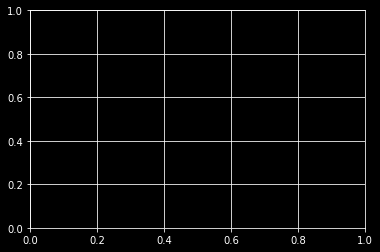

In [335]:
plt.style.use("dark_background")

fig, ax = plt.subplots()
ax.grid(True)

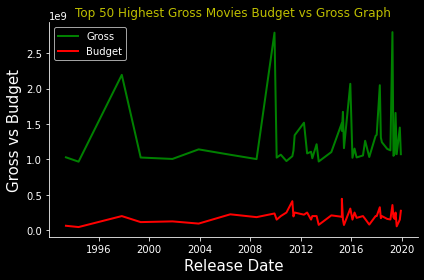

In [349]:
# first sort the values according to the release date
df.sort_values(by=["Release date"],inplace=True)
plt.plot(df["Release date"],df["Gross"],color="green",linewidth=2,label="Gross")

plt.plot(df["Release date"],df["Budget"],color="red",label="Budget",linewidth=2)

plt.title("Top 50 Highest Gross Movies Budget vs Gross Graph",color="y")
plt.xlabel("Release Date",fontsize=15)
plt.ylabel("Gross vs Budget",fontsize=15)

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.grid(False)

plt.tight_layout()
plt.legend()
